In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from datasets import load_dataset


/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
dataset = load_dataset("gsm8k", "main")
train_questions = dataset["train"]["question"]
train_answers = dataset["train"]["answer"]

In [66]:
len(train_questions)

7473

In [32]:
train_question_lens = np.array([len(question)+len("\nAnswer: ") for question in train_questions])
train_answer_lens = np.array([len(answer) for answer in train_answers])

In [52]:
train_answers_small = np.array([int(answer[answer.find("#### ") + len("#### "):].replace(",", "")) for answer in train_answers])

In [13]:
len(likelihoods)

7473

In [15]:
train_question_lens*likelihoods

array([ 68.56600988, 112.1341542 ,  71.42041636, ..., 243.32627887,
       300.53106308,  29.4966315 ])

In [20]:
checkpoints = ["00500", "05000", "10000", "15000", "20000", "25000", "30000", "35000", "40000", "45000", "50000"]
likelihoods_all = []
for checkpoint in checkpoints:
    model_path = f"ckpts/sft_gsm8k_llama7B_full3/checkpoint_{checkpoint}/hf_model/"
    likelihoods = np.load(os.path.join(model_path, "trainpts_answer_log_probs_mean_all2.npy"))
    # likelihoods = likelihoods*train_question_lens
    likelihoods = np.e ** likelihoods
    likelihoods_all.append(likelihoods)
    print(likelihoods.mean())
likelihoods_all = np.array(likelihoods_all)

0.5986104
0.6795229
0.7026185
0.7123671
0.7132159
0.7182645
0.724342
0.70159554
0.715343
0.72587574
0.7170329


(array([0.00000000e+00, 2.38095238e-01, 5.87474120e-01, 2.80020704e-01,
        0.00000000e+00, 9.57556936e-02, 3.51966874e-02, 9.83436853e-03,
        3.10559006e-03, 5.17598344e-04]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

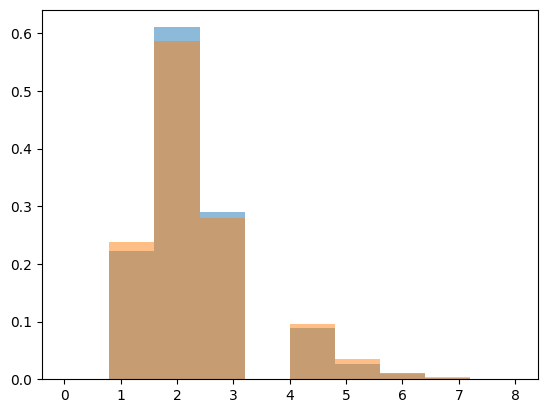

In [71]:
increasing_idxs = np.where(likelihoods_all[-1, :] > likelihoods_all[0, :])[0]
decreasing_idxs = np.where(likelihoods_all[-1, :] <= likelihoods_all[0, :])[0]
train_answers_small_len = np.array([len(str(answers_small)) for answers_small in train_answers_small])

plt.hist(train_answers_small_len[increasing_idxs], density=True, alpha=0.5, range=(0, 8))
plt.hist(train_answers_small_len[decreasing_idxs], density=True, alpha=0.5, range=(0, 8))

In [57]:
# np.array(train_questions)[increasing_idxs]

for question in np.array(train_questions)[increasing_idxs]:
    print(question)

Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?
Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?
Albert is wondering how much pizza he can eat in one day. He buys 2 large pizzas and 2 small pizzas. A large pizza has 16 slices and a small pizza has 8 slices. If he eats it all, how many pieces does he eat that day?
Ken created a care package to send to his brother, who was away at boarding school.  Ken placed a box on a scale, and then he poured into the box enough jelly beans to br

In [59]:
# print(np.array(train_questions)[decreasing_idxs])

for question in np.array(train_questions)[decreasing_idxs]:
    print(question)

Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?
A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?
Tobias is buying a new pair of shoes that costs $95. He has been saving up his money each month for the past three months. He gets a $5 allowa

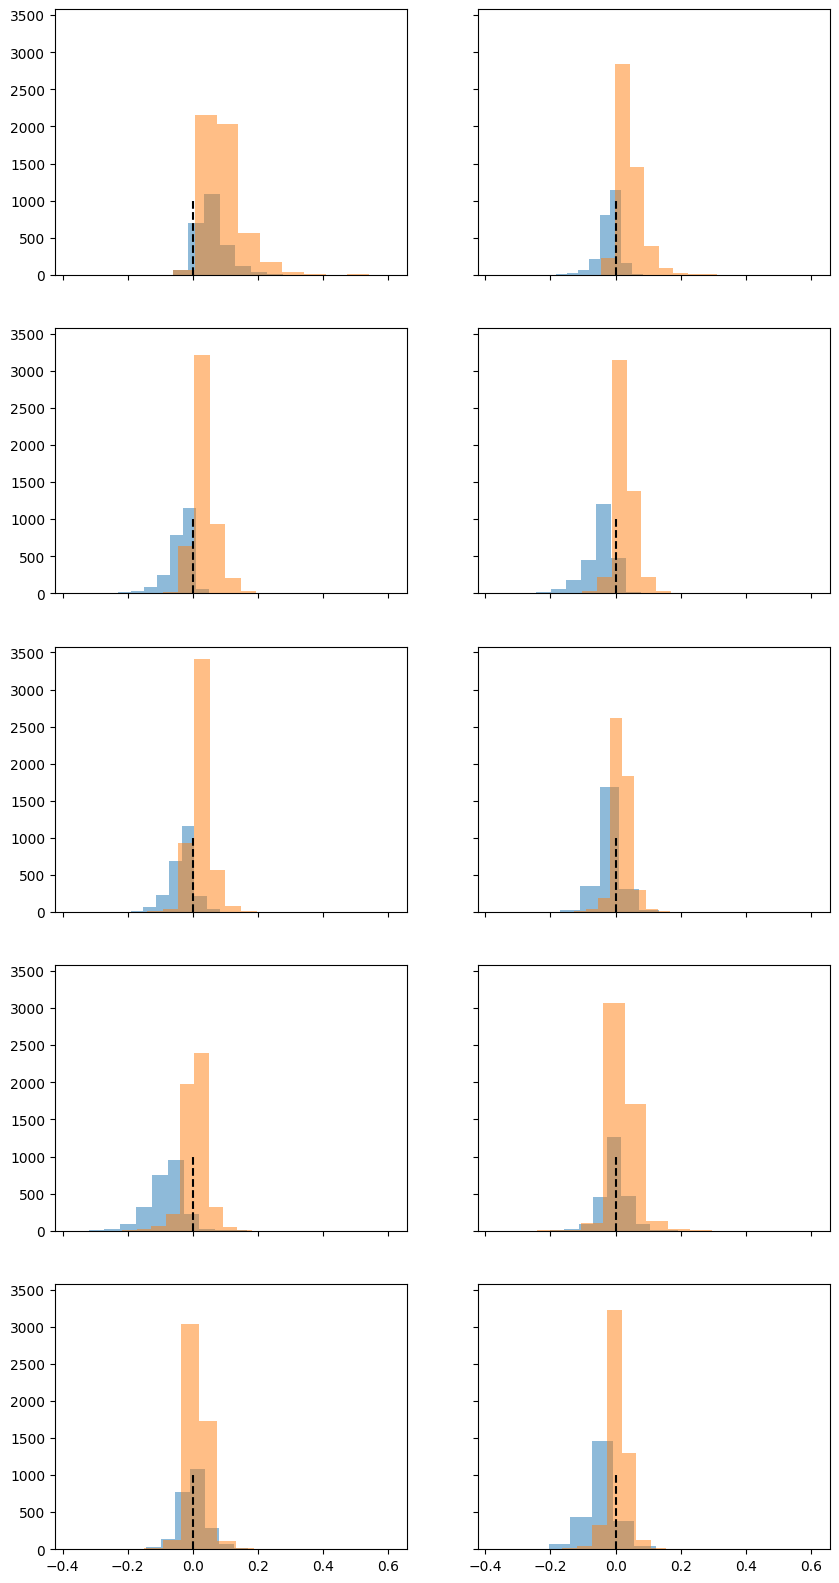

In [65]:

#make 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 20), sharex=True, sharey=True)

likelihoods_all.shape


for i in range(10):
    ax = axs[i//2, i%2]
    ax.hist(likelihoods_all[i+1, decreasing_idxs]-likelihoods_all[i, decreasing_idxs], alpha=0.5)
    ax.hist(likelihoods_all[i+1, increasing_idxs]-likelihoods_all[i, increasing_idxs], alpha=0.5)
    ax.vlines(0, 0, 1000, color="black", linestyle="--")

Text(0.5, 1.0, 'Finetuning data')

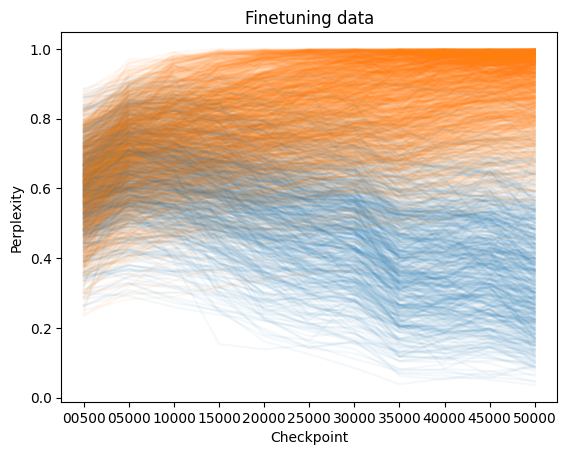

In [21]:
for i in range(2000):
    if likelihoods_all[-1, i] > likelihoods_all[0, i]:
        plt.plot(likelihoods_all[:, i], c = "C1", alpha = 0.05)
    else:
        plt.plot(likelihoods_all[:, i], c = "C0", alpha = 0.05)

plt.xlabel("Checkpoint")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.ylabel("Perplexity")
plt.title("Finetuning data")